# Imports

In [ ]:
from operator import xor
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

import sys
sys.path.insert(0,'/content/drive/Shareddrives/CS389/Code')
# from CNN import CNN

In [ ]:
!pip install trains
!pip install optuna

from trains.automation import UniformParameterRange, UniformIntegerParameterRange
from trains.automation import HyperParameterOptimizer
from trains.automation.optuna import OptimizerOptuna

from trains import Task

# task = Task.init(project_name='Hyper-Parameter Search', task_name='Hyper-Parameter Optimization')


     |████████████████████████████████| 855 kB 28.5 MB/s 
     |████████████████████████████████| 86 kB 3.5 MB/s 
     |████████████████████████████████| 308 kB 33.3 MB/s 
     |████████████████████████████████| 210 kB 65.3 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 146 kB 78.9 MB/s 
     |████████████████████████████████| 112 kB 73.4 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=58f470714b10491f16987832f6334953e6aa9637d5518e7946cbb02c5e60ac0b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN Class

In [ ]:
# PSEUDO ALEXNET
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #the inital image shape is (3, 300, 210)        

        self.linear_block = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
          nn.ReLU(),
          nn.MaxPool2d((2, 2)),
          nn.Dropout(0.1),
          nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=(3, 3)), 
          nn.ReLU(),
          nn.MaxPool2d((2, 2)),
          nn.Dropout(0.1),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
          nn.Dropout(0.1),
          nn.Flatten(),
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(445312, 1)
        )



    def forward(self, x):
        x = x.reshape(-1, 3, 300, 210)
        # x = self.conv_block1(x)
        # x = self.conv_block2(x)
        # x = self.conv_block3(x)
        # x = self.linear_block(x)
        x = self.linear_block(x)
        # print(x.shape)

        # x = self.linear_block(x)
        # x = self.layer1(x)
        # print(x.shape)

        return x
    
    def predict_firstconv(self,x):
      x = x.reshape(-1, 3, 300, 210)
      x = self.conv_block1(x)
      return x

# Hyperparameters

In [ ]:
# Hyperparamters
loadModel = False
saveModel = True
batch = 17
n_epochs = 2
learning_rate = .008771978191790283
update_interval = 10
loss_function = nn.L1Loss()
crop_width = 300  # Average Width of the cropped image is 320
crop_height = 210  # Average Height of the cropped image is 230
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
seed = 25

# Copy the Picture Dataset

In [ ]:
!cp -av '/content/drive/Shareddrives/CS389/Code' '/content'

'/content/drive/Shareddrives/CS389/Code' -> '/content/Code'
'/content/drive/Shareddrives/CS389/Code/network.py' -> '/content/Code/network.py'
'/content/drive/Shareddrives/CS389/Code/CNN_Project.py' -> '/content/Code/CNN_Project.py'
'/content/drive/Shareddrives/CS389/Code/CNN.py' -> '/content/Code/CNN.py'
'/content/drive/Shareddrives/CS389/Code/__pycache__' -> '/content/Code/__pycache__'
'/content/drive/Shareddrives/CS389/Code/__pycache__/CNN.cpython-39.pyc' -> '/content/Code/__pycache__/CNN.cpython-39.pyc'
'/content/drive/Shareddrives/CS389/Code/__pycache__/dataset.cpython-39.pyc' -> '/content/Code/__pycache__/dataset.cpython-39.pyc'
'/content/drive/Shareddrives/CS389/Code/__pycache__/network.cpython-39.pyc' -> '/content/Code/__pycache__/network.cpython-39.pyc'
'/content/drive/Shareddrives/CS389/Code/__pycache__/CNN.cpython-37.pyc' -> '/content/Code/__pycache__/CNN.cpython-37.pyc'
'/content/drive/Shareddrives/CS389/Code/__pycache__/dataset.cpython-37.pyc' -> '/content/Code/__pycache__/

# Unzip the dataset

In [ ]:
!unzip /content/drive/Shareddrives/CS389/thecarconnectionpicturedataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2019_90_19_330_30_6_76_56_198_19_AWD_4_4_4dr_pio.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2019_90_19_330_30_6_76_56_198_19_AWD_4_4_4dr_rMQ.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2019_90_19_330_30_6_76_56_198_19_AWD_4_4_4dr_uRu.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_Ami.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_Asc.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_BbI.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_bma.jpg  
  inflating: thecarconnectionpicturedataset/Porsche_Panamera_2020_103_21_330_30_6_76_56_198_19_RWD_4_4_4dr_bum.jpg  
  inflating: the

# Load the Dataset

## Dataset Class

In [ ]:
class dataset():
    def __init__(self,filepath,crop_width,crop_height,batch,train=True,seed=25):
        self.crop_width = crop_width
        self.crop_height = crop_height
        # self.filepath = os.path.realpath(os.path.join(os.path.dirname(__file__), "..", filepath))
        self.batch = batch
        self.seed = seed
        self.train_URLs, self.test_URLs = self.split_set()
        # self.dataset, self.test_set, self.dataset_features, self.test_features = self.load_dataset(crop_width, crop_height, batch, train)
        self.train = train
        
    
    # Get Methods
    def getTrainURLs(self):
      return self.train_URLs

    def getTestURLs(self):
      return self.test_URLs

    def getCropWidth(self):
        return self.crop_width
    
    def getCropHeight(self):
        return self.crop_height
    
    def getFilepath(self):
        return self.filepath
    
    def getBatch(self):
        return self.batch
    
    def getDataset(self):
        return self.dataset
    
    def getTestSet(self):
        return self.test_set
    
    def getDatasetFeatures(self):
        return self.dataset_features
    
    def getTestFeatures(self):
        return self.test_features
    
    def getTrain(self):
        return self.train

    def split_set(self): # Splits the data into a test and training set url
      dataset = []
      directory = "/content/thecarconnectionpicturedataset"
      print(self.seed)
      for file in tqdm(os.listdir(directory)):
        dataset.append(file)
      # Splits the dataset into training and test sets
      URL_training_Set, URL_test_set = train_test_split(dataset, test_size=0.3, random_state=self.seed)
      return (URL_training_Set, URL_test_set)


    def batch_loader(self, dataset):
      batch_size = self.batch
      crop_width = self.crop_width
      crop_height = self.crop_height
      # print(len(dataset))
      def foo():
        if(len(dataset) < batch_size):
          return (np.array([]),np.array([]))

        else:
          # print(len(dataset))
          batch = []
          feature_batch = []
          count = 0

          while count != batch_size and len(dataset)!=0:
            image = dataset.pop(0)
            img_features = np.array(image.split("_"))  # Gets the features from the file name
            feature_batch.append([int(img_features[3])])

            img = Image.open(os.path.join("/content/thecarconnectionpicturedataset", image))
            width = img.size[0]
            height = img.size[1]
            left = (width - crop_width) / 2
            top = (height - crop_height) / 2
            right = left + crop_width
            bottom = top + crop_height
            # Cropped image of above dimension
            # (It will not change original image)
            img = img.crop((left, top, right, bottom))
            img = np.asarray(img).reshape(3, 300, 210)
            batch.append(img)
            count +=1
          
          return (np.array(batch), np.array(feature_batch))

      return foo  
       
    # Finds the average image dimension of the dataset
    # def Find_Average_Image_Dimension(self):
    #     width = 0
    #     height = 0
    #     number_Of_Images = 0
    #     directory = os.path.realpath(os.path.join(os.path.dirname(__file__), "..", "thecarconnectionpicturedataset"))
    #     for file in tqdm(os.listdir(directory)):
    #         filepath = os.path.join(directory,file)
    #         img = Image.open(filepath) # Opens the Image
    #         number_Of_Images +=1
    #         width += img.size[0]
    #         height += img.size[1]
    #     width = width/number_Of_Images
    #     height = height/ number_Of_Images
    #     return (width,height)


    # Returns a random image from the dataset
    def getRandomImage(self):
        return self.dataset[random.randint(0, 10)]
    
    # Plots an image from the dataset given an image
    def plot_image(self, image):
        image = image.reshape(-1,self.crop_height,self.crop_width,3)
        plt.imshow(image[0])
        plt.show()

    # Plots a random image from the dataset
    def plotRandomImage(self):
        image = self.getRandomImage()
        self.plot_image(image)

## Create a dataset object

In [ ]:
data = dataset(filepath="thecarconnectionpicturedataset",crop_width=crop_width,crop_height=crop_height,batch=batch,train=True,seed=seed)

25


100%|██████████| 36108/36108 [00:00<00:00, 2864480.13it/s]


## Plots a random Image from the dataset

In [ ]:
# data.plotRandomImage() 

# Initialize the Network

## Network Class

In [ ]:
class network():
    def __init__(self,data,loadModel,saveModel,batch,n_epochs,learning_rate,update_interval,loss_function,model,optimizer):
        self.data = data
        self.loadModel = loadModel
        self.saveModel = saveModel
        self.batch = batch
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.update_interval = update_interval
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        
    def getData(self):
        return self.data
    
    def getModel(self):
        return self.model
    
    def getOptimizer(self):
        return self.optimizer

    def getLossFunction(self):
        return self.loss_function
    
    def getBatch(self):
        return self.batch
    
    def getNepochs(self):
        return self.n_epochs
    
    def getLearningRate(self):
        return self.learning_rate
    
    def getUpdateInterval(self):
        return self.update_interval
    
    def getSaveModel(self):
        return self.saveModel
    
    def getLoadModel(self):
        return self.loadModel
            
    def load_model(self):
        directory = "/content/drive/Shareddrives/CS389/SavedStates/modelState.pt"
        self.model = torch.load(directory)

    # def save_model(self,r):
    #     direct = os.path.realpath(os.path.join(os.path.dirname("ModelState.pt"), "SavedStates"))
    #     torch.save(r[0].state_dict(), direct)

    
    def train_model(self):

        numberOfBatches = len(self.data.getTrainURLs())/self.batch
        model = self.model
        optimizer = self.optimizer
        loss_function = self.loss_function
        n_epochs = self.n_epochs
        update_interval = self.update_interval
        losses = []

        for n in range(n_epochs):
            iterator = 0
            loader = self.data.batch_loader(self.data.getTrainURLs().copy())
            
            for i in tqdm(range(math.floor(numberOfBatches))):
              
                dataset,featureSet = loader()
                featureSet = np.log(featureSet)

                optimizer.zero_grad()
                dataset = torch.from_numpy(dataset).float().to(self.device)
                my_output = model(dataset)
                loss = loss_function(my_output, torch.from_numpy(featureSet).float().to(self.device))
                loss.backward()
                optimizer.step()

                if iterator % update_interval == 0:
                    losses.append(round(loss.item(), 2))
                iterator+=1


        return model, losses


    def test_model(self):
        model = self.model
        loss_function = self.loss_function
        numberOfBatches = len(self.data.getTestURLs())/self.batch
        loader = self.data.batch_loader(self.data.getTestURLs().copy())
        
        # test_label = self.data.getTestFeatures()

        sum_loss = 0
        n_correct = 0
        total = 0

        counter = 0
        for i in tqdm(range(math.floor(numberOfBatches))):
            test_data,test_label = loader()
            test_label = np.log(test_label)
            # This is essentially exactly the same as the training loop
            # without the, well, training, part
            tensor_label = torch.from_numpy(test_label).float().to(self.device)
            test_data = torch.from_numpy(test_data).float().to(self.device)
            pred = model(test_data)
            loss = loss_function(pred, tensor_label)
            sum_loss += loss.item()


            n_correct += (abs(pred - tensor_label) <= 0.45).sum()

            # for i in range(pred):
            #   if abs(pred[i] - tensor_label[i]) <= 0.45:
            #     counter = counter + 1

            # if (pred - 0.45 <= pred) and (pred <= 0.45 + pred):
            #   counter += 1

            _, predicted = torch.max(pred, 1)
            n_correct += (abs(pred - tensor_label) <= 0.45).sum()
            # total += tensor_label.size(0)

        test_acc = round(((n_correct / numberOfBatches*self.getBatch()).item() * 100), 2)
        avg_loss = round(sum_loss / numberOfBatches, 2)

        print("Test Accuracy: ", test_acc)
        print("test loss in Log Space:", avg_loss)
        print("test loss in Linear Space:", np.exp(avg_loss))
        return test_acc, avg_loss

    
    def train_and_test(self):
        update_interval = self.update_interval
        batch_size = self.batch
        print(batch_size)
        trained_model, losses = self.train_model()

        test_acc, test_loss = self.test_model()

        plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, label="training loss")
        plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
        plt.title("training curve")
        plt.xlabel("number of images trained on")
        plt.ylabel("Reconstruction loss")
        # path = os.path.realpath(os.path.join(os.path.dirname(__file__), "..", "graphs", "training.png"))
        path = os.path.realpath(os.path.join("drive","Shareddrives","CS389","graphs","training.png"))
        # Saves the model if saveModel is True
        if(self.saveModel):
            directory = "/content/drive/Shareddrives/CS389/SavedStates/modelState.pt"
            torch.save(trained_model, directory)

        plt.savefig(path)
        plt.show()

        # visualize the first conv layer filters

        # for i, filter in enumerate(model_weights[0]):
        #     plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
        #     plt.imshow(filter[0, :, :].detach())
        #     plt.axis('off')
        #     # plt.savefig('../outputs/filter.png')
        # plt.show()
        # display_filters(self.model.filtered[0].detach().numpy())
        
        return trained_model, test_loss




## Create an instance of the network given the hyperparameters

In [ ]:
neural_network = network(data,loadModel,saveModel,batch,n_epochs,learning_rate,update_interval,loss_function,model,optimizer)


# Train the model / Load the Model

In [ ]:
trainModel = True

17


100%|██████████| 637/637 [00:27<00:00, 23.16it/s]


Test Accuracy:  36116.33
test loss in Log Space: 0.45
test loss in Linear Space: 1.568312185490169


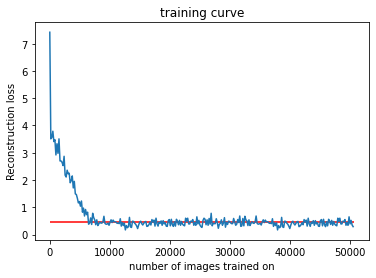

In [ ]:
if(not trainModel):
    if(loadModel):
      neural_network.load_model()
      print("testing 1")
      neural_network.test_model()
    else:
      print("You Must Load the Model")
else:
    if(loadModel):
      neural_network.load_model()
    losses = neural_network.train_and_test()

# Hyperparameter Testing

In [ ]:
!pip install optuna

[I 2022-05-08 23:32:26,989] A new study created in memory with name: no-name-8510fe00-a089-4575-a1cf-9209b5d83d1c


25


100%|██████████| 36108/36108 [00:00<00:00, 2354234.86it/s]


37


100%|██████████| 292/292 [00:26<00:00, 10.83it/s]


Test Accuracy:  127358.84
test loss in Log Space: 0.63
test loss in Linear Space: 1.8776105792643432


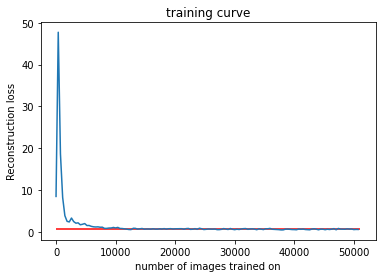

[I 2022-05-08 23:35:10,333] Trial 0 finished with value: 0.63 and parameters: {'batch': 37, 'lr': 5.320237975241157e-05, 'epochs': 2}. Best is trial 0 with value: 0.63.


25


100%|██████████| 36108/36108 [00:00<00:00, 3174276.98it/s]


40


100%|██████████| 270/270 [00:26<00:00, 10.31it/s]


Test Accuracy:  137358.06
test loss in Log Space: 0.66
test loss in Linear Space: 1.9347923344020317


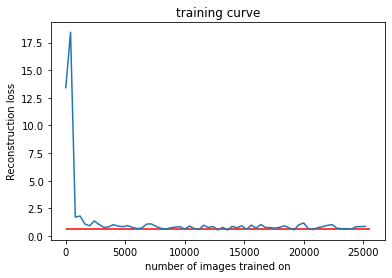

[I 2022-05-08 23:36:45,714] Trial 1 finished with value: 0.66 and parameters: {'batch': 40, 'lr': 0.0012112766808605663, 'epochs': 1}. Best is trial 0 with value: 0.63.


25


100%|██████████| 36108/36108 [00:00<00:00, 3082721.23it/s]


26


100%|██████████| 416/416 [00:26<00:00, 15.92it/s]


Test Accuracy:  65734.19
test loss in Log Space: 0.59
test loss in Linear Space: 1.803988415397857


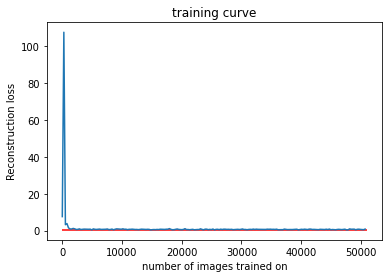

[I 2022-05-08 23:39:24,786] Trial 2 finished with value: 0.59 and parameters: {'batch': 26, 'lr': 0.00014586667016505147, 'epochs': 2}. Best is trial 2 with value: 0.59.


25


100%|██████████| 36108/36108 [00:00<00:00, 3020501.17it/s]


39


100%|██████████| 277/277 [00:26<00:00, 10.35it/s]


Test Accuracy:  178425.81
test loss in Log Space: 0.47
test loss in Linear Space: 1.5999941932173602


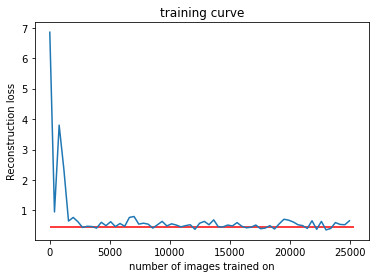

[I 2022-05-08 23:40:56,936] Trial 3 finished with value: 0.47 and parameters: {'batch': 39, 'lr': 0.021681515754428136, 'epochs': 1}. Best is trial 3 with value: 0.47.


25


100%|██████████| 36108/36108 [00:00<00:00, 2639661.32it/s]


31


100%|██████████| 349/349 [00:25<00:00, 13.50it/s]


Test Accuracy:  106949.29
test loss in Log Space: 0.52
test loss in Linear Space: 1.6820276496988864


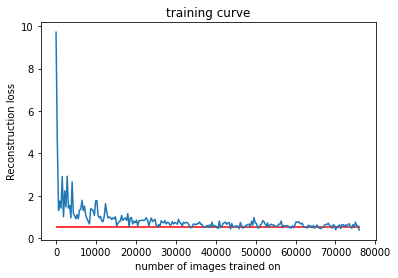

[I 2022-05-08 23:44:32,055] Trial 4 finished with value: 0.52 and parameters: {'batch': 31, 'lr': 0.0014935935553393148, 'epochs': 3}. Best is trial 3 with value: 0.47.


25


100%|██████████| 36108/36108 [00:00<00:00, 2665069.93it/s]


37


100%|██████████| 292/292 [00:27<00:00, 10.76it/s]


Test Accuracy:  66320.61
test loss in Log Space: 1.2
test loss in Linear Space: 3.3201169227365472


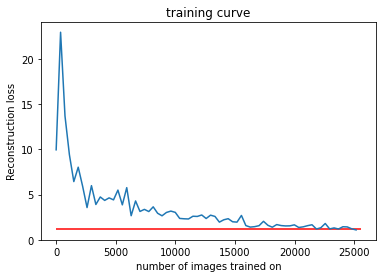

[I 2022-05-08 23:46:04,888] Trial 5 finished with value: 1.2 and parameters: {'batch': 37, 'lr': 1.492660159484759e-05, 'epochs': 1}. Best is trial 3 with value: 0.47.


25


100%|██████████| 36108/36108 [00:00<00:00, 1578783.13it/s]


20


100%|██████████| 541/541 [00:26<00:00, 20.17it/s]


Test Accuracy:  41214.81
test loss in Log Space: 0.56
test loss in Linear Space: 1.7506725002961012


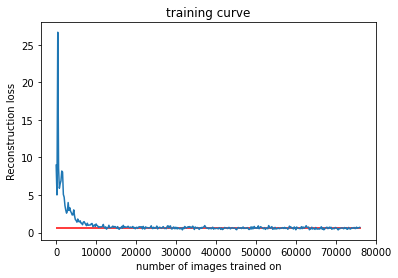

[I 2022-05-08 23:49:51,449] Trial 6 finished with value: 0.56 and parameters: {'batch': 20, 'lr': 2.9145811002921967e-05, 'epochs': 3}. Best is trial 3 with value: 0.47.


25


100%|██████████| 36108/36108 [00:00<00:00, 2544488.05it/s]


24


100%|██████████| 451/451 [00:26<00:00, 17.02it/s]


Test Accuracy:  51501.3
test loss in Log Space: 0.61
test loss in Linear Space: 1.8404313987816374


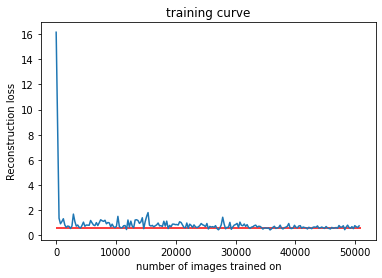

[I 2022-05-08 23:52:32,976] Trial 7 finished with value: 0.61 and parameters: {'batch': 24, 'lr': 0.0010965141761121733, 'epochs': 2}. Best is trial 3 with value: 0.47.


25


100%|██████████| 36108/36108 [00:00<00:00, 1608325.06it/s]


16


 96%|█████████▋| 1520/1579 [01:04<00:02, 23.61it/s]


KeyboardInterrupt: ignored

In [ ]:
# lr = [1e-5,1e-6,1e-7]

# data = dataset
# losses = []

# data = dataset(filepath="thecarconnectionpicturedataset",crop_width=crop_width,crop_height=crop_height,batch=batch,train=True)

# for lr in lr:
#   neural_network = network(data,loadModel,saveModel,batch,n_epochs,lr,update_interval,loss_function,model,optimizer)
#   train_losses = neural_network.train_and_test()
#   losses.append(train_losses[-1])
#   print("final loss", train_losses[-1])


# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])

# learning_rates = ["1e-5","1e-6","1e-7"]

# final_losses = losses

# ax.bar(learning_rates,final_losses)
# ax.set_ylabel('Final Training Loss')
# ax.set_xlabel('Learning Rate')

# plt.show()

import optuna

def objective(trial): 
  batchs = trial.suggest_int('batch', 16,40)
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  n_epochs = trial.suggest_int('epochs', 1, 3)
  seedR = 25   # trial.suggest_int('seed', 20, 50)

  
  loadModel = False
  saveModel = False
  update_interval = 10
  loss_function = nn.L1Loss()
  crop_width = 300  # Average Width of the cropped image is 320
  crop_height = 210  # Average Height of the cropped image is 230
  model = CNN()
  data = dataset(filepath="thecarconnectionpicturedataset",crop_width=crop_width,crop_height=crop_height,batch=batchs,train=True, seed= seedR)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # update_interval = 10
  # crop_width = 300  # Average Width of the cropped image is 320
  # crop_height = 210  # Average Height of the cropped image is 230
  neural_network = network(data,loadModel,saveModel,batchs, n_epochs, learning_rate, update_interval,loss_function,model,optimizer)
  newMod, train_losses = neural_network.train_and_test()

  return train_losses 

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Minimum mean squared error: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))




In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

# Display the Convolutional Layers

In [ ]:
def display_filters(params, name):

    '''
    This is a little bit of code I wrote that will plot out an arbitrary
    number of images in one big plot so that it works for whatever size conv you used
    '''


    fig = plt.figure(figsize=(10, 7)) ## You MIGHT need to change this if you made really big convolutions

    # rows = len(params)//5 + 1
    rows = 1
    for i,filter in enumerate(params):
        if(i > 4):
          break
        fig.add_subplot(rows, 5, i+1)
        plt.imshow(filter)
        plt.axis('off')
        plt.title(name + "filter #"+str(i))
    
    plt.show

## Example using display function

- Displays the convolutions of the first 5 images from the dataset

In [ ]:
params = model.parameters()
conv1_params = next(params)[:,0,:,:].detach().cpu().numpy() # 
relu = next(params)
conv2_params = next(params)[:,0,:,:].detach().cpu().numpy() # 
relu = next(params)
conv3_params = next(params)[:,0,:,:].detach().cpu().numpy() # 

# Code to plot the weights of the first convolution layer
display_filters(conv1_params, "Layer 1 ")

# Code to plot the weights of the second convolution layer
display_filters(conv2_params, "Layer 2 ")

display_filters(conv3_params, "Layer 3 ")

# Visualize the Convolutions

Step 1: Retrieve the Convolutional Layer and their weights

In [ ]:
# Adds the 3 2d Convolutional Layers to the model (Not very neat but brute force works some times :))


count = 0
conv_positions = [0,3,6]
conv_layers = []
for parameter in model.parameters():
  if(count in conv_positions):
    conv_layers.append(parameter)
  count+=1


plt.figure(figsize=(20, 17))
for i, filter in enumerate(conv_layers[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu())
    plt.axis('off')
plt.show()


In [ ]:
import cv2 as cv

# Directory of the image, can make random
dir = "/content/thecarconnectionpicturedataset/Jaguar_XE_2019_41_17_180_20_4_77_56_183_30_AWD_5_4_4dr_sRO.jpg"

img = plt.imread(dir)
plt.imshow(img)
plt.show()

# pass the image through all the layers

results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# # visualize 64 features from each layer 
# # (although there are more feature maps in the upper layers)
# for num_layer in range(len(outputs)):
#     plt.figure(figsize=(30, 30))
#     layer_viz = outputs[num_layer][0, :, :, :]
#     layer_viz = layer_viz.data
#     print(layer_viz.size())
#     for i, filter in enumerate(layer_viz):
#         if i == 64: # we will visualize only 8x8 blocks from each layer
#             break
#         plt.subplot(8, 8, i + 1)
#         plt.imshow(filter, cmap='gray')
#         plt.axis("off")
#     print(f"Saving layer {num_layer} feature maps...")
#     # plt.savefig(f"../outputs/layer_{num_layer}.png")
#     plt.show()
#     plt.close()

# Test Images

In [ ]:
# # plot feature map of first conv layer for given image
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.models import Model
# from matplotlib import pyplot
# from numpy import expand_dims

# # load the model
# model = CNN()
# # redefine model to output right after the first hidden layer

# # model = CNN()

# # load the image with the required shape
# img = load_img('/content/thecarconnectionpicturedataset/Jaguar_XE_2019_41_17_180_20_4_77_56_183_30_AWD_5_4_4dr_sRO.jpg', target_size=(300, 210))
# # convert the image to an array
# # img = img_to_array(img)
# # # expand dimensions so that it represents a single 'sample'
# # img = expand_dims(img, axis=0)
# # # prepare the image (e.g. scale pixel values for the vgg)
# # img = preprocess_input(img)

# img = np.asarray(img).reshape(3, 300, 210)
# img = torch.from_numpy(img)
# # get feature map for first hidden layer
# img = img.type(torch.FloatTensor)

# feature_maps = model.predict_firstconv(img)
# feature_maps = feature_maps.detach().numpy()
# # plot all 64 maps in an 8x8 squares
# square = 8
# ix = 1
# pyplot.figure(figsize=(30, 30))

# for _ in range(square):
# 	for _ in range(square):
# 		# specify subplot and turn of axis
# 		ax = pyplot.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
# 		# plot filter channel in grayscale
# 		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray') 
# 		ix += 1
# # show the figure
# pyplot.show()

In [ ]:
!pip install fc_model

# Upload an image from your file system

In [ ]:
# upload external file before import
from google.colab import files

imported_file = files.upload()

Saving 2021_honda_civic_4dr-hatchback_type-r_fq_oem_1_1600.jpeg to 2021_honda_civic_4dr-hatchback_type-r_fq_oem_1_1600 (1).jpeg


# Run the Image through the model

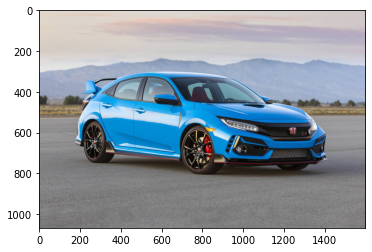

Model Price of the Image in Linear Space:  36.953194
Actual Price of the Image in Log Space:  3.609652
The MSRP of your Car is: $ 36953.19366455078


In [ ]:
img = list(imported_file.keys())[0]

dir = "/content/thecarconnectionpicturedataset/Jaguar_XE_2019_41_17_180_20_4_77_56_183_30_AWD_5_4_4dr_sRO.jpg"


img = Image.open(img)
a = img.copy()
plt.imshow(img)

plt.show() 

img = np.array(a)
# print(img)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img.resize(3,300, 210)
img = torchvision.transforms.functional.to_tensor(img).float().to(device)

price = neural_network.getModel()(img)
price = price.sum().cpu().detach().numpy()


print("Model Price of the Image in Linear Space: ",np.exp(price))
print("Actual Price of the Image in Log Space: ", price)

price = np.exp(price)
# if(price*1000 < 10,000):
#   print("Not a valid car")
# else:
print("The MSRP of your Car is: $",price*1000)
# print("Actual Price is: $","28,000")